100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Device: cuda

--- Training ResNet50 baseline (finetune end-to-end) ---
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]
/tmp/ipython-input-3443089284.py:228: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/6


  0%|          | 0/1563 [00:00<?, ?it/s]/tmp/ipython-input-3443089284.py:191: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-3443089284.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train loss 0.3347 acc 0.8902 | Val loss 0.1907 acc 0.9348
Epoch 2/6


Train loss 0.1816 acc 0.9397 | Val loss 0.1798 acc 0.9399
Epoch 3/6


Train loss 0.1424 acc 0.9513 | Val loss 0.1511 acc 0.9491
Epoch 4/6


Train loss 0.1150 acc 0.9611 | Val loss 0.1513 acc 0.9502
Epoch 5/6


Train loss 0.0932 acc 0.9676 | Val loss 0.2168 acc 0.9353
Epoch 6/6


Train loss 0.0877 acc 0.9699 | Val loss 0.2140 acc 0.9351


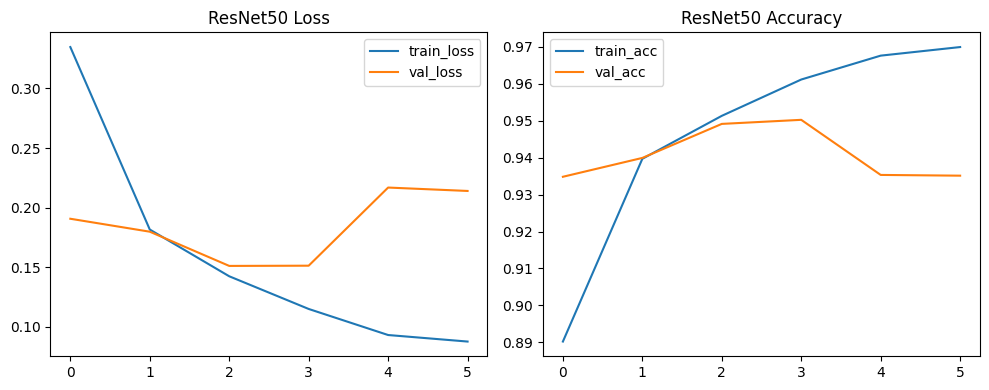

Best validation acc (resnet): 0.9502


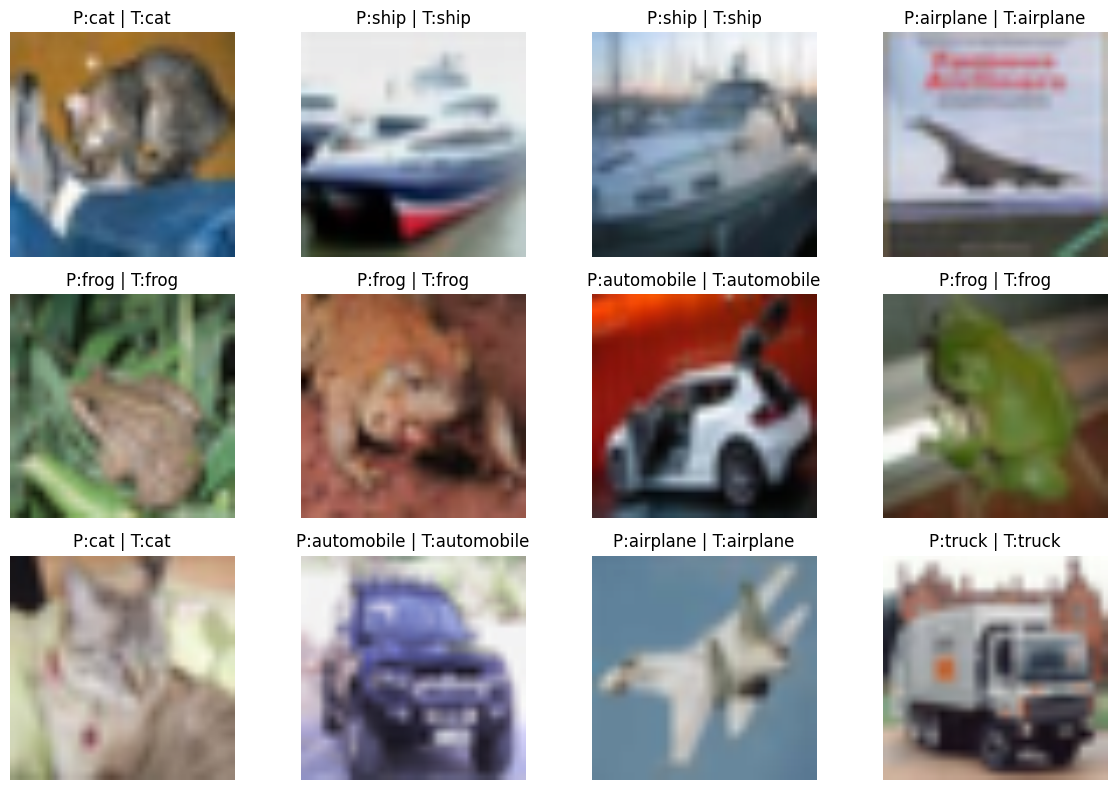


--- Training MobileNetV2 baseline (finetune end-to-end) ---
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s]


Epoch 1/6


Train loss 0.3756 acc 0.8751 | Val loss 0.2006 acc 0.9306
Epoch 2/6


Train loss 0.1867 acc 0.9353 | Val loss 0.1987 acc 0.9339
Epoch 3/6


Train loss 0.1397 acc 0.9529 | Val loss 0.1685 acc 0.9428
Epoch 4/6


Train loss 0.1067 acc 0.9644 | Val loss 0.1634 acc 0.9442
Epoch 5/6


Train loss 0.0880 acc 0.9694 | Val loss 0.1666 acc 0.9475
Epoch 6/6


Train loss 0.0758 acc 0.9736 | Val loss 0.1845 acc 0.9425


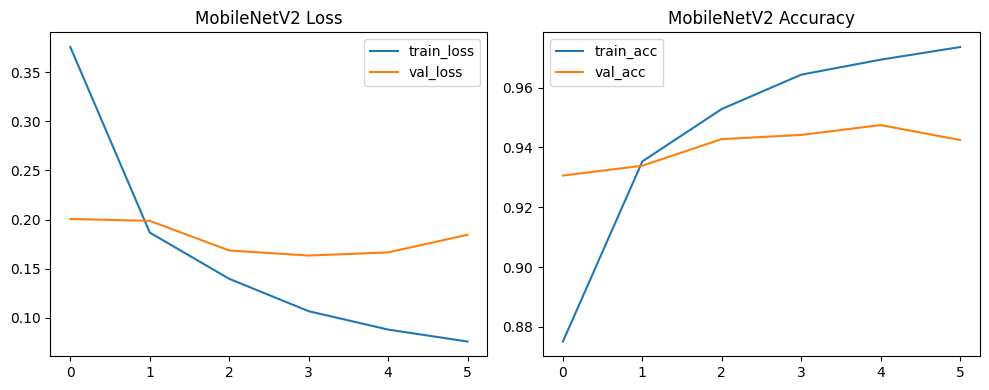

Best validation acc (mobilenet): 0.9475


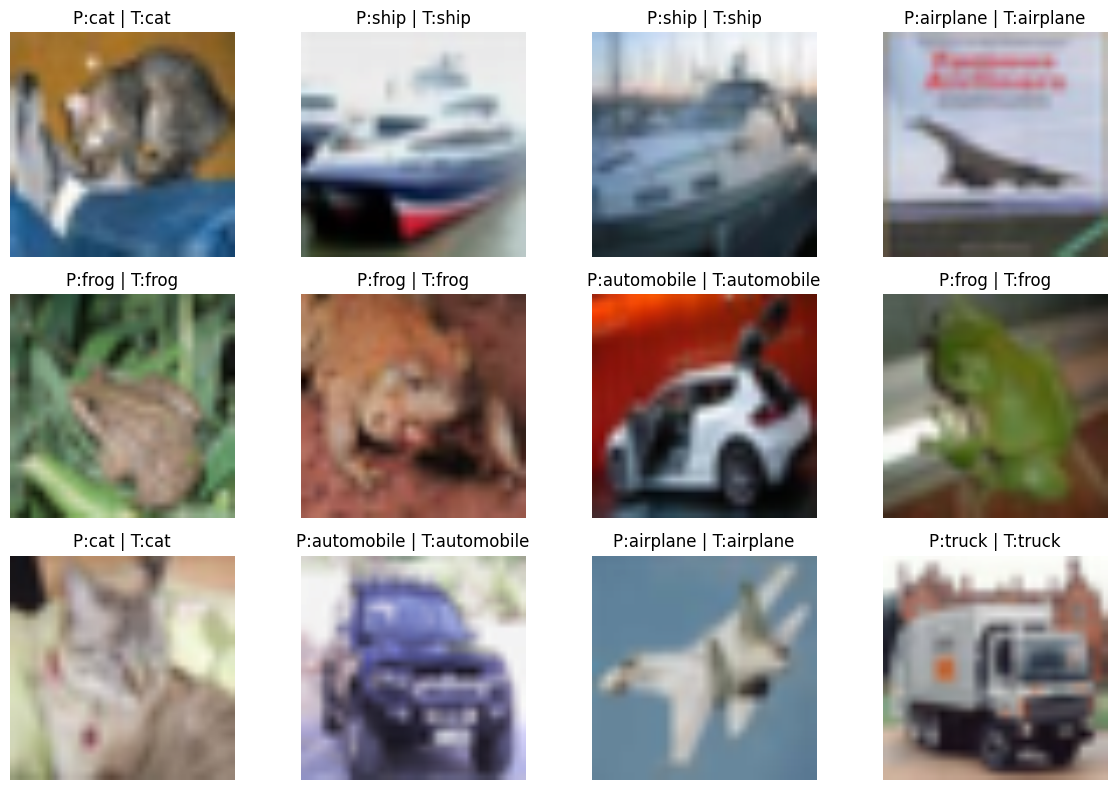


--- Training Fusion model (ResNet50 + MobileNetV2) - frozen backbones ---
Epoch 1/6


Train loss 0.7371 acc 0.7531 | Val loss 0.4806 acc 0.8296
Epoch 2/6


Train loss 0.5570 acc 0.8068 | Val loss 0.4882 acc 0.8319
Epoch 3/6


Train loss 0.5223 acc 0.8195 | Val loss 0.4426 acc 0.8418
Epoch 4/6


Train loss 0.5100 acc 0.8248 | Val loss 0.4300 acc 0.8497
Epoch 5/6


Train loss 0.4929 acc 0.8277 | Val loss 0.4160 acc 0.8498
Epoch 6/6


Train loss 0.4838 acc 0.8329 | Val loss 0.4089 acc 0.8540


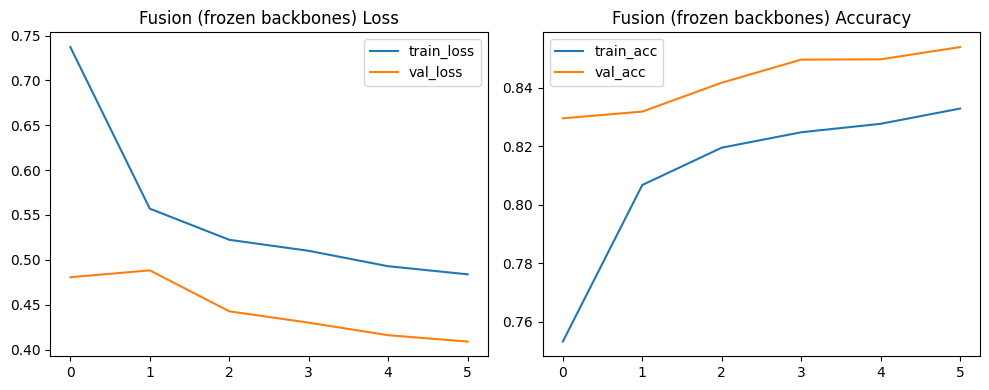

Best validation acc (fusion frozen): 0.854


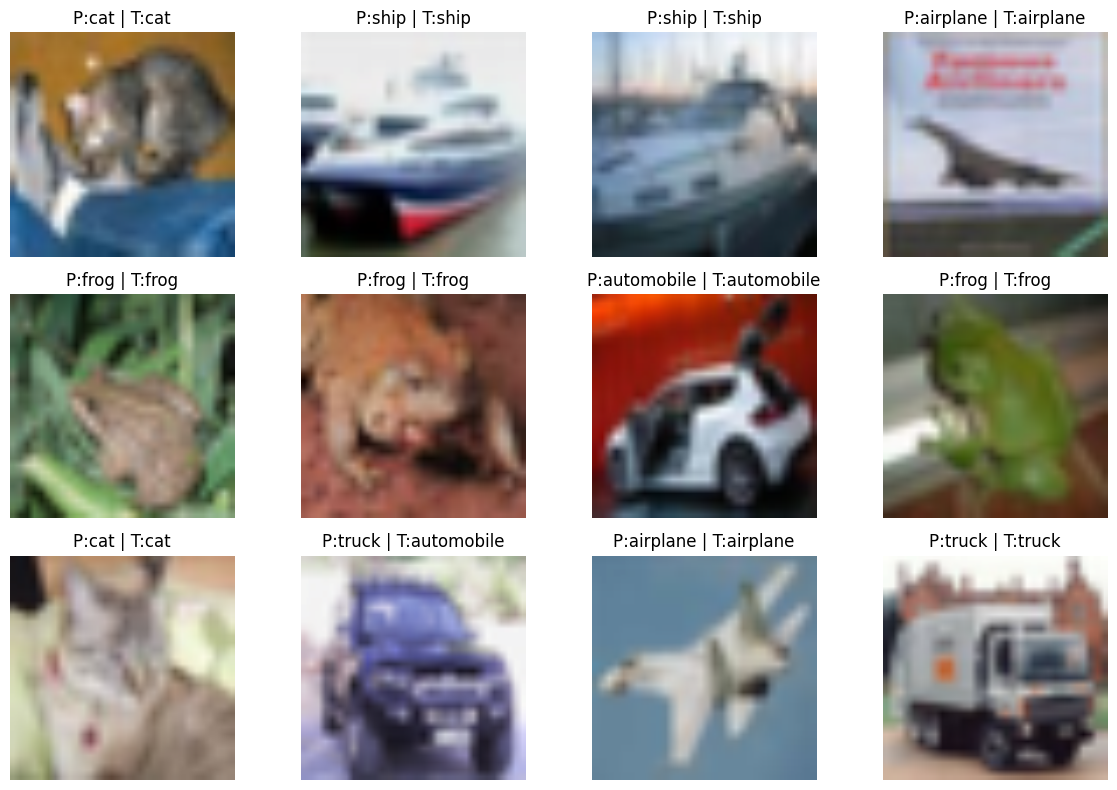


--- Training Fusion model - finetune last blocks ---
Epoch 1/6


Train loss 0.8298 acc 0.7459 | Val loss 0.4085 acc 0.8634
Epoch 2/6


Train loss 0.4667 acc 0.8419 | Val loss 0.3452 acc 0.8798
Epoch 3/6


Train loss 0.3999 acc 0.8645 | Val loss 0.3105 acc 0.8914
Epoch 4/6


Train loss 0.3674 acc 0.8742 | Val loss 0.2915 acc 0.8981
Epoch 5/6


Train loss 0.3387 acc 0.8847 | Val loss 0.2822 acc 0.9005
Epoch 6/6


Train loss 0.3142 acc 0.8919 | Val loss 0.2726 acc 0.9038


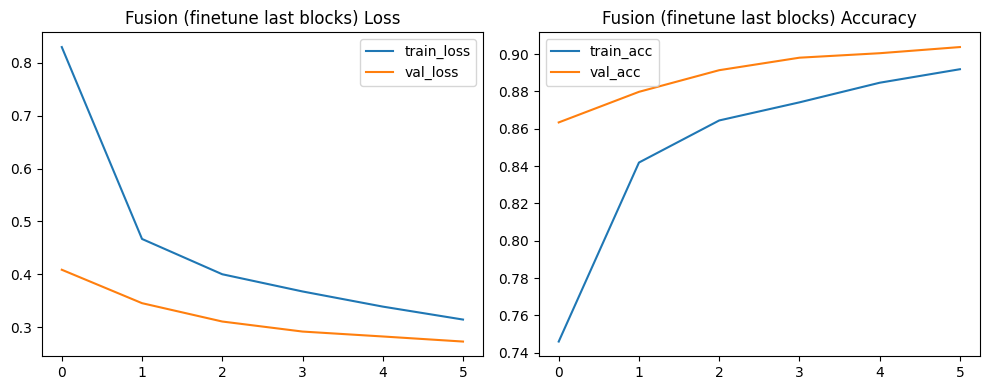

Best validation acc (fusion finetune last blocks): 0.9038


In [1]:
# Image Classification - Fusion of ResNet50 + MobileNetV2 (PyTorch)
# Fixed version (Grad-CAM bug + some robustness fixes)

import os
import random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

# ---------------------------
# Config / Hyperparameters
# ---------------------------
class CFG:
    seed = 42
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data_dir = "./data"
    out_dir = "./outputs"
    img_size = 224  # upsample CIFAR-10 from 32 -> 224 for ImageNet pretrained
    batch_size = 32
    batch_size_fusion = 16
    epochs = 6  # adjust (3 for quick test, 10-30 for proper training)
    lr_baseline = 1e-4
    lr_fusion = 1e-4
    num_workers = 4
    num_classes = 10
    weight_decay = 1e-5
    save_model = True
    seed_everything = True

os.makedirs(CFG.out_dir, exist_ok=True)

# ---------------------------
# Utilities
# ---------------------------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

if CFG.seed_everything:
    seed_all(CFG.seed)

def device():
    return torch.device(CFG.device)

# ---------------------------
# Dataloaders
# ---------------------------
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(CFG.img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

def get_dataloaders(batch_size=32, data_dir=CFG.data_dir):
    train_set = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    val_set = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=val_transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                            num_workers=CFG.num_workers, pin_memory=True)
    return train_loader, val_loader, train_set.classes

# ---------------------------
# Models
# ---------------------------
class FusionModel(nn.Module):
    """
    ResNet50 (2048-d) + MobileNetV2 (1280-d) -> concat -> fusion head
    Options:
    - freeze_backbones: if True, backbones' params are not trainable
    - finetune_last_block: allow last conv block of each backbone to train (if not fully frozen)
    """
    def __init__(self, num_classes=10, freeze_backbones=True, finetune_last_block=False, pretrained=True):
        super().__init__()
        self.num_classes = num_classes

        # ResNet50 backbone
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
        # remove final fc
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])  # outputs (B,2048,1,1)
        self.resnet_dim = 2048

        # MobileNetV2 backbone
        mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None)
        self.mobilenet_features = mobilenet.features  # outputs (B,1280,H/32,W/32)
        self.mobilenet_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mobilenet_dim = 1280

        # Optionally freeze backbones
        if freeze_backbones:
            for p in self.resnet_features.parameters():
                p.requires_grad = False
            for p in self.mobilenet_features.parameters():
                p.requires_grad = False

        # Optionally finetune last block: simple approach by enabling grad for last few layers
        if finetune_last_block:
            # Unfreeze last ResNet stage (layer4)
            for name, module in self.resnet_features.named_children():
                if name == 'layer4':
                    for p in module.parameters():
                        p.requires_grad = True
            # Unfreeze last few modules of mobilenet.features
            for module in list(self.mobilenet_features.children())[-4:]:
                for p in module.parameters():
                    p.requires_grad = True

        # Fusion head
        fusion_in = self.resnet_dim + self.mobilenet_dim
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_in, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # ResNet path
        r = self.resnet_features(x)              # (B,2048,1,1)
        r = torch.flatten(r, 1)                  # (B,2048)

        # MobileNet path
        m = self.mobilenet_features(x)           # (B,1280,H/32,W/32)
        m = self.mobilenet_pool(m)               # (B,1280,1,1)
        m = torch.flatten(m, 1)                  # (B,1280)

        # Concat and classification
        fused = torch.cat([r, m], dim=1)         # (B,3328)
        out = self.fusion_head(fused)
        return out

# Baseline builder: simple wrappers to adapt classifier output to CIFAR-10
def build_resnet50(num_classes=10, pretrained=True, finetune_all=True):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    if not finetune_all:
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True
    return model

def build_mobilenetv2(num_classes=10, pretrained=True, finetune_all=True):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    if not finetune_all:
        for p in model.parameters():
            p.requires_grad = False
        for p in model.classifier[1].parameters():
            p.requires_grad = True
    return model

# ---------------------------
# Training & Evaluation
# ---------------------------
def accuracy_from_logits(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    pbar = tqdm(loader, leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        b = imgs.shape[0]
        running_loss += loss.item() * b
        running_acc += accuracy_from_logits(logits, labels) * b
        n += b
        pbar.set_description(f"loss: {running_loss/n:.4f} acc: {running_acc/n:.4f}")
    return running_loss / n, running_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with autocast():
            logits = model(imgs)
            loss = criterion(logits, labels)
        b = imgs.shape[0]
        running_loss += loss.item() * b
        running_acc += accuracy_from_logits(logits, labels) * b
        n += b
    return running_loss / n, running_acc / n

# ---------------------------
# Training harness
# ---------------------------
def run_training(model, train_loader, val_loader, lr=1e-4, epochs=3, save_name="model.pt"):
    model = model.to(device())
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=CFG.weight_decay)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_val_acc = 0.0
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device())
        val_loss, val_acc = evaluate(model, val_loader, criterion, device())
        print(f"Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        if val_acc > best_val_acc and CFG.save_model:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(CFG.out_dir, save_name))
    return history, best_val_acc

# ---------------------------
# Visualizations
# ---------------------------
def plot_history(history, title_prefix="model"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend(); plt.title(f"{title_prefix} Loss")
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend(); plt.title(f"{title_prefix} Accuracy")
    plt.tight_layout()
    plt.show()

def show_sample_predictions(model, loader, classes, device, n=12):
    model.eval()
    imgs, labels = next(iter(loader))
    imgs_cpu = imgs.clone()
    imgs, labels = imgs.to(device), labels.to(device)
    with torch.no_grad():
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()

    # unnormalize for display
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    plt.figure(figsize=(12,8))
    for i in range(n):
        plt.subplot(3,4,i+1)
        img = imgs_cpu[i].permute(1,2,0).numpy()  # HWC
        img = (img * std) + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"P:{classes[preds[i]]} | T:{classes[labels[i].cpu().item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ---------------------------
# Grad-CAM - robust implementation
# ---------------------------
class SimpleGradCAM:
    """
    Simple Grad-CAM implementation.
    Attach to a convolutional module (e.g. resnet.layer4).
    Usage:
        cam = SimpleGradCAM(model=resnet_model, target_module=target_module)
        mask = cam.generate_cam(input_tensor, target_class)
    """
    def __init__(self, model, target_module):
        self.model = model
        self.target_module = target_module
        self.activations = None
        self.gradients = None
        self.handles = []
        # register hooks using the modern APIs
        self.handles.append(self.target_module.register_forward_hook(self._forward_hook))
        # register_full_backward_hook ensures we get gradients for module outputs
        if hasattr(self.target_module, "register_full_backward_hook"):
            self.handles.append(self.target_module.register_full_backward_hook(self._backward_hook))
        else:
            # fallback for older versions (deprecated)
            self.handles.append(self.target_module.register_backward_hook(self._backward_hook))

    def _forward_hook(self, module, input, output):
        # output shape (B, C, H, W)
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output is a tuple; we want the gradient w.r.t. module output
        self.gradients = grad_output[0].detach()

    def remove_hooks(self):
        for h in self.handles:
            try:
                h.remove()
            except Exception:
                pass
        self.handles = []

    def generate_cam(self, input_tensor, class_idx=None):
        """
        input_tensor: shape (1, C, H, W) on same device as model
        returns cam (H, W) normalized 0..1 numpy array
        """
        self.model.zero_grad()
        self.activations = None
        self.gradients = None

        # Ensure model in eval mode for deterministic activations (no dropout)
        was_training = self.model.training
        self.model.eval()

        outputs = self.model(input_tensor)
        if class_idx is None:
            class_idx = outputs.argmax(dim=1).item()
        # select the score for the target class for the first example
        score = outputs[0, class_idx]
        # backward to populate gradients
        score.backward(retain_graph=False)

        # check hooks captured
        if self.gradients is None or self.activations is None:
            self.model.train(was_training)
            raise RuntimeError("Grad-CAM hooks did not capture activations/gradients. "
                               "Make sure target_module is the right convolutional block and model parameters require gradients.")

        grads = self.gradients[0]  # (C, H, W)
        acts = self.activations[0]  # (C, H, W)
        weights = grads.mean(dim=(1,2), keepdim=True)  # (C,1,1)
        cam = (weights * acts).sum(dim=0)  # (H,W)
        cam = F.relu(cam)
        if cam.max() != 0:
            cam = cam - cam.min()
            cam = cam / (cam.max() + 1e-8)
        cam_np = cam.cpu().numpy()
        # restore training state
        self.model.train(was_training)
        return cam_np

def overlay_cam_on_image(img, cam, alpha=0.4):
    # img: numpy HxWx3 (0..1), cam: HxW (0..1)
    import cv2
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)[..., ::-1] / 255.0
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlay = img * (1-alpha) + heatmap * alpha
    return np.clip(overlay, 0, 1)

# ---------------------------
# Running experiments
# ---------------------------
if __name__ == "__main__":
    # 1) get data
    train_loader, val_loader, classes = get_dataloaders(batch_size=CFG.batch_size)
    print("Classes:", classes)
    print("Device:", device())

    # ------------------------------------------------------------------
    # Example experiment 1: ResNet50 baseline (finetune end-to-end)
    # ------------------------------------------------------------------
    print("\n--- Training ResNet50 baseline (finetune end-to-end) ---")
    resnet = build_resnet50(num_classes=CFG.num_classes, pretrained=True, finetune_all=True)
    hist_resnet, best_acc_resnet = run_training(resnet, train_loader, val_loader,
                                                lr=CFG.lr_baseline, epochs=CFG.epochs,
                                                save_name="resnet50_best.pt")
    plot_history(hist_resnet, "ResNet50")
    print("Best validation acc (resnet):", best_acc_resnet)
    show_sample_predictions(resnet.to(device()), val_loader, classes, device())

    # ------------------------------------------------------------------
    # Example experiment 2: MobileNetV2 baseline (finetune end-to-end)
    # ------------------------------------------------------------------
    print("\n--- Training MobileNetV2 baseline (finetune end-to-end) ---")
    mobilenet = build_mobilenetv2(num_classes=CFG.num_classes, pretrained=True, finetune_all=True)
    hist_mobilenet, best_acc_mobilenet = run_training(mobilenet, train_loader, val_loader,
                                                      lr=CFG.lr_baseline, epochs=CFG.epochs,
                                                      save_name="mobilenetv2_best.pt")
    plot_history(hist_mobilenet, "MobileNetV2")
    print("Best validation acc (mobilenet):", best_acc_mobilenet)
    show_sample_predictions(mobilenet.to(device()), val_loader, classes, device())

    # ------------------------------------------------------------------
    # Example experiment 3: Fusion model (frozen backbones; train fusion head)
    # ------------------------------------------------------------------
    print("\n--- Training Fusion model (ResNet50 + MobileNetV2) - frozen backbones ---")
    train_loader_f, val_loader_f, _ = get_dataloaders(batch_size=CFG.batch_size_fusion)
    fusion_frozen = FusionModel(num_classes=CFG.num_classes, freeze_backbones=True, finetune_last_block=False, pretrained=True)
    hist_fusion, best_acc_fusion = run_training(fusion_frozen, train_loader_f, val_loader_f,
                                                lr=CFG.lr_fusion, epochs=CFG.epochs,
                                                save_name="fusion_frozen_best.pt")
    plot_history(hist_fusion, "Fusion (frozen backbones)")
    print("Best validation acc (fusion frozen):", best_acc_fusion)
    show_sample_predictions(fusion_frozen.to(device()), val_loader_f, classes, device())

    # ------------------------------------------------------------------
    # Experiment 4 (recommended): Fusion with finetuning last blocks
    # ------------------------------------------------------------------
    print("\n--- Training Fusion model - finetune last blocks ---")
    fusion_finetune = FusionModel(num_classes=CFG.num_classes, freeze_backbones=True, finetune_last_block=True, pretrained=True)
    hist_fusion_ft, best_acc_fusion_ft = run_training(fusion_finetune, train_loader_f, val_loader_f,
                                                      lr=1e-5, epochs=CFG.epochs,
                                                      save_name="fusion_finetune_best.pt")
    plot_history(hist_fusion_ft, "Fusion (finetune last blocks)")
    print("Best validation acc (fusion finetune last blocks):", best_acc_fusion_ft)




Loaded model weights from ./outputs/resnet50_best.pt


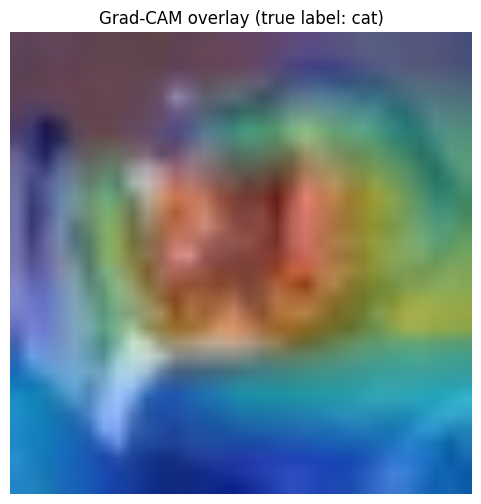

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Use the existing classes and imagenet mean/std from your code
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Assuming build_resnet50 and SimpleGradCAM classes are already defined

device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load validation dataset (for example, just to get samples)
_, val_loader, classes = get_dataloaders(batch_size=32, data_dir=CFG.data_dir)

# Get one image and label from val_loader
imgs, labels = next(iter(val_loader))
img = imgs[0:1].to(device_)
label = labels[0].item()

# Build ResNet50 model with pretrained weights (finetune_all=False to freeze all except classifier)
resnet_cpu = build_resnet50(num_classes=CFG.num_classes, pretrained=True, finetune_all=False).to(device_)

# Load best checkpoint weights if available
resnet_path = os.path.join(CFG.out_dir, "resnet50_best.pt")
if os.path.exists(resnet_path):
    resnet_cpu.load_state_dict(torch.load(resnet_path, map_location=device_))
    print(f"Loaded model weights from {resnet_path}")
else:
    print("Warning: resnet50_best.pt not found. Using current model weights (may be untrained).")

# Set model to eval mode
resnet_cpu.eval()

# Make sure gradients are enabled for Grad-CAM
for param in resnet_cpu.parameters():
    param.requires_grad = True

# Select the target convolutional module for Grad-CAM
target_module = resnet_cpu.layer4

# Initialize Grad-CAM
cam_tool = SimpleGradCAM(resnet_cpu, target_module)

# Generate Grad-CAM mask
cam = cam_tool.generate_cam(img, class_idx=None)  # cam shape (H, W), normalized 0..1

# Unnormalize the image for visualization
img_np = imgs[0].permute(1, 2, 0).cpu().numpy()
img_np = (img_np * np.array(imagenet_std)) + np.array(imagenet_mean)
img_np = np.clip(img_np, 0, 1)

# Overlay CAM on the image
def overlay_cam_on_image(img, cam, alpha=0.4):
    import cv2
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)[..., ::-1] / 255.0
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlay = img * (1 - alpha) + heatmap * alpha
    return np.clip(overlay, 0, 1)

overlay = overlay_cam_on_image(img_np, cam)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Grad-CAM overlay (true label: {classes[label]})")
plt.axis('off')
plt.show()

# Remove hooks to avoid memory leaks
cam_tool.remove_hooks()
